In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras 
from keras.preprocessing.image import ImageDataGenerator ,img_to_array , load_img
from keras.applications.vgg19 import VGG19 , preprocess_input , decode_predictions

In [2]:
train_datagen = ImageDataGenerator(zoom_range = 0.5 , shear_range = 0.3 , horizontal_flip = True , preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [3]:
train = train_datagen.flow_from_directory(directory="./PlantVillage/train",
                                          target_size=(256,256),
                                         batch_size=32)
val = val_datagen.flow_from_directory(directory="./PlantVillage/val",
                                          target_size=(256,256),
                                         batch_size=32)

Found 44016 images belonging to 39 classes.
Found 11004 images belonging to 39 classes.


In [4]:
    t_img , label = train.next ( )

In [5]:
def plotImage ( img_arr , label ) :
    for im , l in zip ( img_arr , label ) :
        plt.figure ( figsize = ( 5,5 ) )
        plt.imshow(im)
        plt.show ( )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


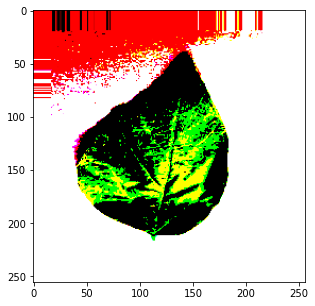

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


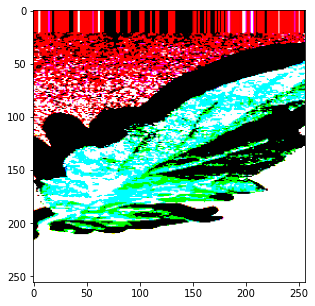

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


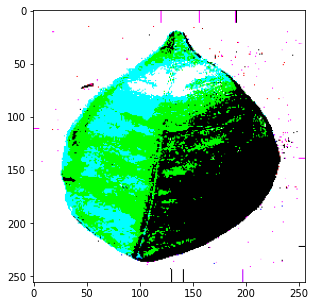

In [6]:
plotImage ( t_img[:3] , label[:3] )

In [7]:
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [8]:
base_model = VGG19(input_shape=(256,256,3), include_top = False)

In [9]:
for layer in base_model.layers :
    layer.trainable = False

In [10]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [11]:
X = Flatten()(base_model.output)
X = Dense(units=39 , activation='softmax')(X)

model = Model(base_model.input,X)


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
model.compile(optimizer='adam'
              ,loss=keras.losses.categorical_crossentropy 
              ,metrics = ['accuracy'])

In [14]:
from keras.callbacks import ModelCheckpoint,EarlyStopping


es = EarlyStopping(monitor = 'val_accuracy' 
                   , min_delta = 0.01 
                   ,patience = 3 
                   ,verbose=1)

mc = ModelCheckpoint(
    filepath="best_model.h5",
    monitor = 'val_accuracy' ,
    min_delta = 0.01 ,
    patience = 3 
    ,verbose=1
    ,save_best_only = True)

cb = [es,mc]

In [15]:
his = model.fit (train ,
                 steps_per_epoch = 16 ,
                 epochs = 50 ,
                 verbose = 1 ,
                 callbacks = cb ,
                 validation_data = val,
                 validation_steps = 16 )

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 23.5417 - accuracy: 0.3105 
Epoch 1: val_accuracy improved from -inf to 0.44922, saving model to best_model.h5
16/16 [==============================] - 630s 40s/step - loss: 23.5417 - accuracy: 0.3105 - val_loss: 14.9970 - val_accuracy: 0.4492
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 13.0234 - accuracy: 0.5312 
Epoch 2: val_accuracy improved from 0.44922 to 0.59375, saving model to best_model.h5
16/16 [==============================] - 598s 39s/step - loss: 13.0234 - accuracy: 0.5312 - val_loss: 10.0665 - val_accuracy: 0.5938
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 12.3293 - accuracy: 0.5664 
Epoch 3: val_accuracy improved from 0.59375 to 0.70117, saving model to best_model.h5
16/16 [==============================] - 689s 45s/step - loss: 12.3293 - accuracy: 0.5664 - val_loss: 8.2153 - val_accuracy: 0.7012
Epoch 4/50
16/16 [==============================] - ETA: 0s

In [17]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

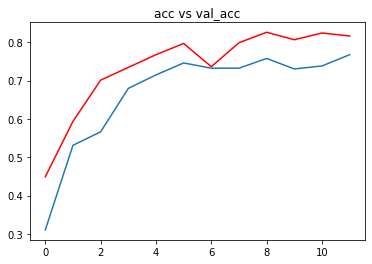

In [18]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red')
plt.title("acc vs val_acc")
plt.show()

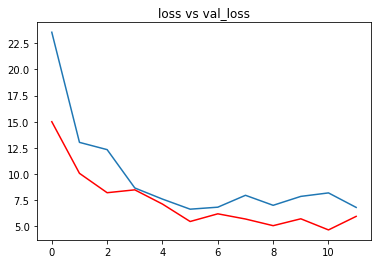

In [19]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c='red')
plt.title("loss vs val_loss")
plt.show()

In [15]:
from keras.models import load_model
model = load_model("best_model.h5")

In [45]:
acc = model.evaluate(val)[1]
print (f"The accuracy of the model is { acc*100 }% ")

344/344 [==============================] - 4588s 13s/step - loss: 5.4575 - accuracy: 0.8184
The accuracy of the model is 81.84296488761902% 


In [16]:
ref = dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

In [32]:
def prediction(path):
    img = load_img(path,target_size=(256,256))
    i=img_to_array(img)
    im = preprocess_input(i)
    img = np.expand_dims(im,axis=0)
    pred = np.argmax(model.predict(img))
    plt.imshow(im)
    print (f"The image belongs to {ref[pred]} ")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image belongs to Cherry_(including_sour)___healthy 


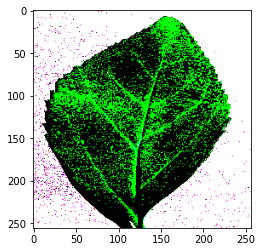

In [33]:
prediction('./test/Cherry_(including_sour)___healthy/1e642352-7ca1-47e3-b408-6e24bf1b45cf___JR_HL 4058.JPG')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image belongs to Grape___Esca_(Black_Measles) 


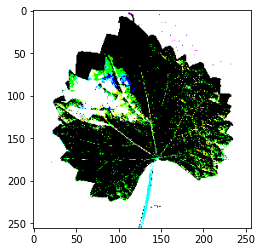

In [34]:
prediction('./test\Grape___Esca_(Black_Measles)/1f4911b2-05bb-4784-99cb-cb1170cf96ba___FAM_B.Msls 0938.JPG')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image belongs to Tomato___Tomato_mosaic_virus 


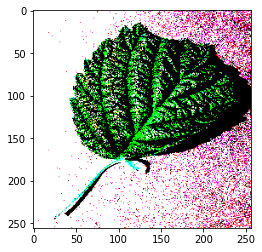

In [35]:
prediction('./test/Raspberry___healthy/7144dcc1-87b5-4c76-9200-965dde6bc779___Mary_HL 9171.JPG')